# Point source likelihood

`icecube_tools` also provides an interface to the likelihoods often used in point source searches of the neutrino data (see [this paper](https://arxiv.org/abs/0801.1604) by Braun et al.).

$$
\mathcal{L} = \prod_{i=1}^N \Bigg[ \frac{n_s}{N} \mathcal{S}(\theta_i, E_i, \gamma) + (1-\frac{n_s}{N}) \mathcal{B}(\theta_i, E_i) \Bigg],
$$
where $N$ is the total number of detected neutrino events, $n_s$ is the expected number of source events, $\theta$ is the neutrino direction, $E$ is the reconstructed neutrino energy and $\gamma$ is the source spectral index.

The point source likelihood is a mixture model with two components: one representing possible astrophysical neutrino sources, $\mathcal{S}(\theta, E)$, and the other known background, $\mathcal{B}(\theta, E)$. Each component has terms depending on the directional or spatial source--neutrino relationship and also the energy of the neutrinos, as higher energy neutrinos are more likely to come from astrophysical sources. Depending on the search, the energy dependence may be omitted. Also, there may be a temporal dependence added, but this is not yet implemented in `icecube_tools`.

Here we implement a simple likelihood and apply it to some simulated data. There are several likelihoods available, and more information can be found in the API documentation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

from icecube_tools.point_source_likelihood.spatial_likelihood import (
    EventDependentSpatialGaussianLikelihood,
)
from icecube_tools.point_source_likelihood.energy_likelihood import (
    MarginalisedEnergyLikelihood2021,
    read_input_from_file,
    MarginalisedIntegratedEnergyLikelihood,
)
from icecube_tools.point_source_likelihood.point_source_likelihood import (
    PointSourceLikelihood,
    TimeDependentPointSourceLikelihood,
)

from icecube_tools.detector.effective_area import EffectiveArea
from icecube_tools.detector.r2021 import R2021IRF
from icecube_tools.detector.detector import IceCube
from icecube_tools.utils.data import Events, SimEvents, RealEvents

## Spatial likelihood

We can start with the spatial/directional term. Let's use the energy dependent spatial likelihood. It is build from a Gaussian with an event-wise uncertainty sampled from the IRF data. The background case will simply be an isotropic distribution on the sphere.

In [2]:
angular_resolution = 5
spatial_likelihood = EventDependentSpatialGaussianLikelihood(angular_resolution)

We show the likelihood profile for a single event with an assumed uncertainty of 1 degree.

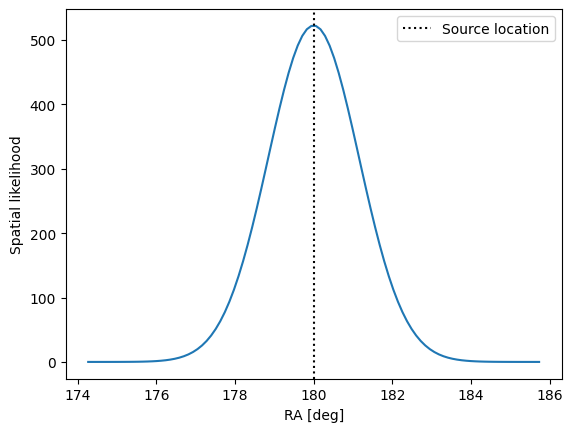

In [3]:
source_coord = (np.pi, np.deg2rad(30))
test_ra = np.pi + np.linspace(-0.1, 0.1, 100)
test_dec = np.full((100), source_coord[1])

fig, ax = plt.subplots()
ax.plot(np.rad2deg(test_ra), spatial_likelihood(1.0, test_ra, test_dec, source_coord))
ax.axvline(
    np.rad2deg(source_coord[0]), color="k", linestyle=":", label="Source location"
)
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Spatial likelihood")
ax.legend()

## Energy likelihood

Now let's think about the energy-dependent term. The way this is handled is to marginalise over the true neutrino energies, to directly connect the reconstructed neutrino energies to the spectral index of a simple power-law source model.

Doing this properly requires a knowledge of the relationship between the true and reconstructed energies as well as the details of the power law model. The most straightforward way to implement this is to simulate the a large number of events using the `Simulator` and build a likelihood using the output of this simulation and `MarginalisedEnergyLikelihoodFromSim`. We do exactly this with pre-computed lists of events, to be found in the data subdirectory: `sim_output_{index}.h5`. These were simulated using point sources with spectral index `index` at 45 degrees declination. The likelihood is restricted to a small band of declination around the assumed source. Using the same declination for our test source, this is fine. For different source declinations further simulations would be needed to account for the declination dependence of the detector acceptance.

In [4]:
aeff = EffectiveArea.from_dataset("20210126", period="IC86_II")
irf = R2021IRF.from_period("IC86_II")
# new_reco_bins = irf.reco_energy_bins[12, 2]
new_reco_bins = np.linspace(1, 9, num=25)
detector = IceCube.from_period("IC86_II")
energy_likelihood = MarginalisedIntegratedEnergyLikelihood(
    "IC86_II", new_reco_bins, max_index=4.5
)
# energy_likelihood = MarginalisedEnergyLikelihood2021([1.5, 2.0, 2.5, 3.0, 3.5, 3.7, 4.0], 'data', 'sim_output', np.pi/4,)
# the likelihood class is backwardscompatible with the "older" simulation-based energy likelihood

In [5]:
new_reco_bins

array([1.        , 1.33333333, 1.66666667, 2.        , 2.33333333,
       2.66666667, 3.        , 3.33333333, 3.66666667, 4.        ,
       4.33333333, 4.66666667, 5.        , 5.33333333, 5.66666667,
       6.        , 6.33333333, 6.66666667, 7.        , 7.33333333,
       7.66666667, 8.        , 8.33333333, 8.66666667, 9.        ])

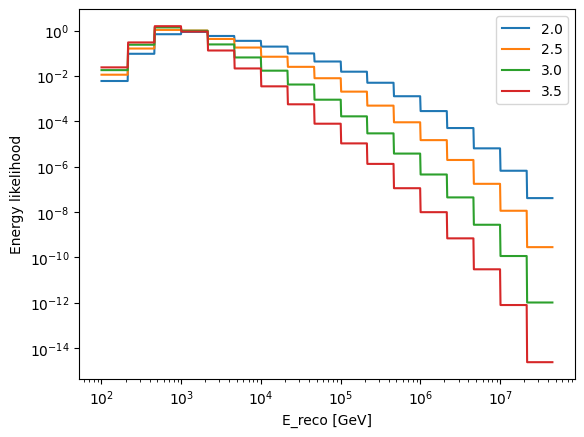

In [6]:
# test_energies = np.geomspace(10, 1e7) # GeV
test_indices = [2.0, 2.5, 3, 3.5]
energy = np.logspace(2, 7.66, num=1000, endpoint=False)
fig, ax = plt.subplots()
for index in test_indices:
    ax.plot(
        energy,
        energy_likelihood(energy, index, np.full(energy.shape, np.deg2rad(45))),
        label=f"{index:.1f}",
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E_reco [GeV]")
ax.set_ylabel("Energy likelihood")
ax.legend()

## Point source likelihood

Now we can bring together the spatial and energy terms to build a full `PointSourceLikelihood`. First, let's load some data from the simulation notebook to allow us to demonstrate.

In [7]:
events = SimEvents.load_from_h5("h5_test.hdf5")

Now lets put our likelihood structure and data in together, along with a proposed source location:

In [8]:
likelihood = PointSourceLikelihood(
    spatial_likelihood,
    energy_likelihood,
    events.ra[events.periods[0]],
    events.dec[events.periods[0]],
    events.reco_energy[events.periods[0]],
    events.ang_err[events.periods[0]],
    source_coord,
    which="both",
)

The likelihood will automatically select a declination band around the proposed source location. Because of the Gaussian spatial likelihood, neutrinos far from the source will have negligible contribution. We can control the width of this band with the optional argument `band_width_factor`. Let's see how many events are there in total, in the selected declination band and in vicinity of the proposed source:

In [9]:
likelihood.Ntot, likelihood.N, likelihood.Nprime

(204, 204, 35)

We also note that the background likelihood is implemented automatically, for more information on the options here, check out the API docs. This is just a function of energy, with a constant factor to account for the isotropic directional likelihood.

Text(0, 0.5, 'Background likelihood')

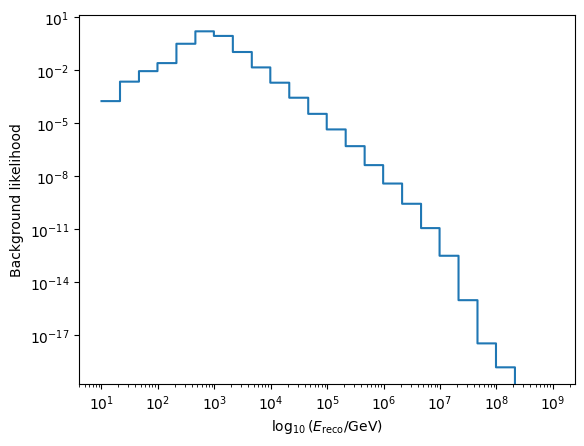

In [10]:
fig, ax = plt.subplots()
energy = np.logspace(new_reco_bins[0], new_reco_bins[-1], num=1000, endpoint=False)
ax.step(
    energy,
    energy_likelihood(energy, 3.7, np.full(energy.shape, np.deg2rad(30))),
    label=f"index 3.7",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\log_{10}{(E_\mathrm{reco} / \mathrm{GeV})}$")
ax.set_ylabel("Background likelihood")

## Point source search

A point source search is usually carried out by defining the likelihood ratio of source and background hypotheses, then maximising this ratio as a function of $n_s$ and $\gamma$. The log likelihood ratio evaluated at the maximum likelihood values is then reffered to as the *test statistic*.

`icecube_tools` includes calculation of the test statistic, with optimisation performed by `iminuit`.

In [11]:
likelihood.get_test_statistic()

379.3319304294439

In [12]:
likelihood._selected_energies.size

35

In [13]:
likelihood.m.values, likelihood.m.errors

(<ValueView ns=25.963806381794907 index=2.301173868863804 weight=0.0 index_astro=2.5 index_atmo=3.7>,
 <ErrorView ns=4.759496039069145 index=0.1908336385491083 weight=0.05 index_astro=0.1 index_atmo=0.1>)

To understand the significance of this results, we would have to calculate the test statistic for a large number of background-only simulations. These could then be used to calculate a p-value. Given there is a strong point source in the simulation we used, we can expect the test stastic to be lower if we remove the source events. Let's try this:

In [14]:
# Get all point source events
ps_sel = events.source_label[events.periods[0]] == 1
ntot_ps_events = len(np.where(ps_sel == True)[0])

# Remove them one by one and find test statistic
test_statistics = []
for n_rm in range(ntot_ps_events):

    i_keep = (ntot_ps_events - n_rm) - 1
    ps_sel[np.where(ps_sel == True)[0][i_keep]] = False

    new_data = {}
    for key in events.keys:
        new_data[key] = events.period(events._periods[0])[key][~ps_sel]

    new_likelihood = PointSourceLikelihood(
        spatial_likelihood,
        energy_likelihood,
        new_data["ra"],
        new_data["dec"],
        new_data["reco_energy"],
        new_data["ang_err"],
        source_coord,
        which="both",
    )
    new_likelihood._bg_energy_likelihood = None
    test_statistics.append(new_likelihood.get_test_statistic())

Text(0, 0.5, 'Test statistic value')

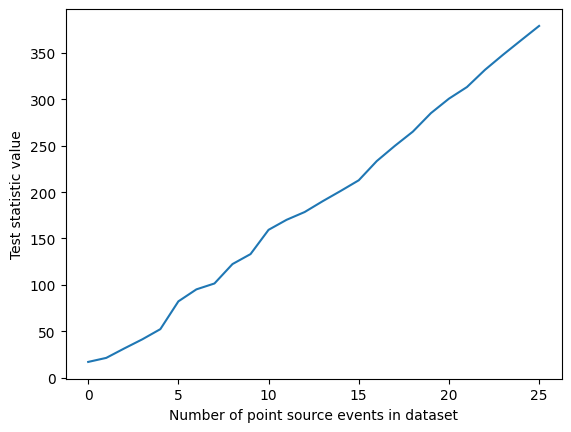

In [15]:
fig, ax = plt.subplots()
ax.plot([_ for _ in range(ntot_ps_events)], test_statistics)
ax.set_xlabel("Number of point source events in dataset")
ax.set_ylabel("Test statistic value")

In [16]:
np.all(np.diff(test_statistics) > 0)

True

So the more neutrinos are seen from a source, the easier that source is to detect.

Let's have a look at the minuit object returned by `_minimize()`. In case something is off with the fit, we can use it as a starting point for debugging.

In [17]:
m = likelihood._minimize()
print(m)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -189.7                     │              Nfcn = 47               │
│ EDM = 1.25e-06 (Goal: 0.0001)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────

We can also draw the likelihood profiles for `ns` and `index` and compare to the inputted values (20 source events and an index of 2.5, cf. the simulation notebook)

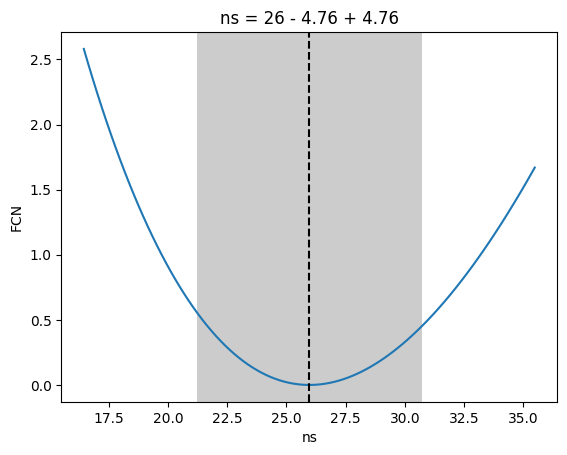

In [18]:
_ = m.draw_profile("ns")

In [19]:
np.nonzero(events.source_label["IC86_II"] == 1)[0].size

26

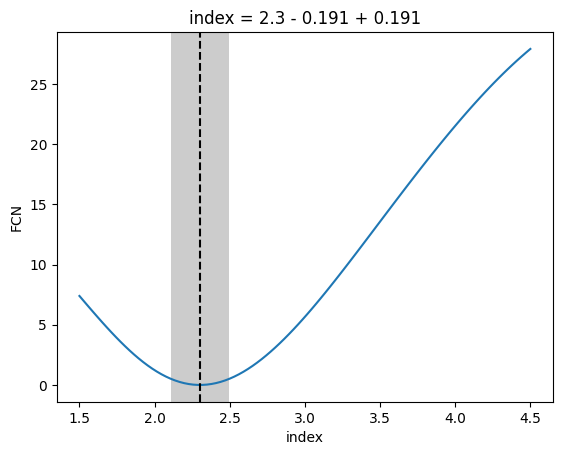

In [20]:
_ = m.draw_profile(
    "index",
    bound=(
        likelihood._energy_likelihood._min_index,
        likelihood._energy_likelihood._max_index,
    ),
)

And finally have a look at the 2d likelihood profile.

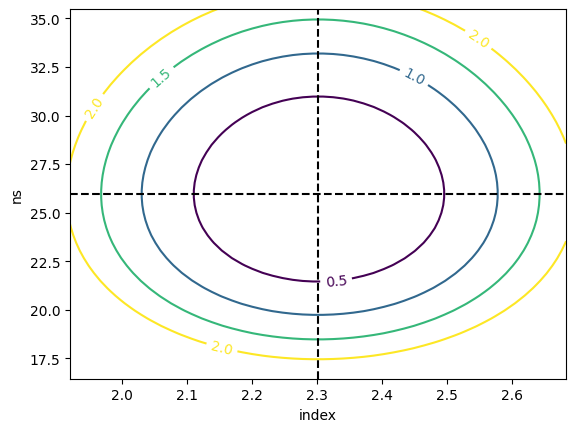

In [21]:
_ = m.draw_contour("index", "ns")

Text(0, 0.5, 'ns')

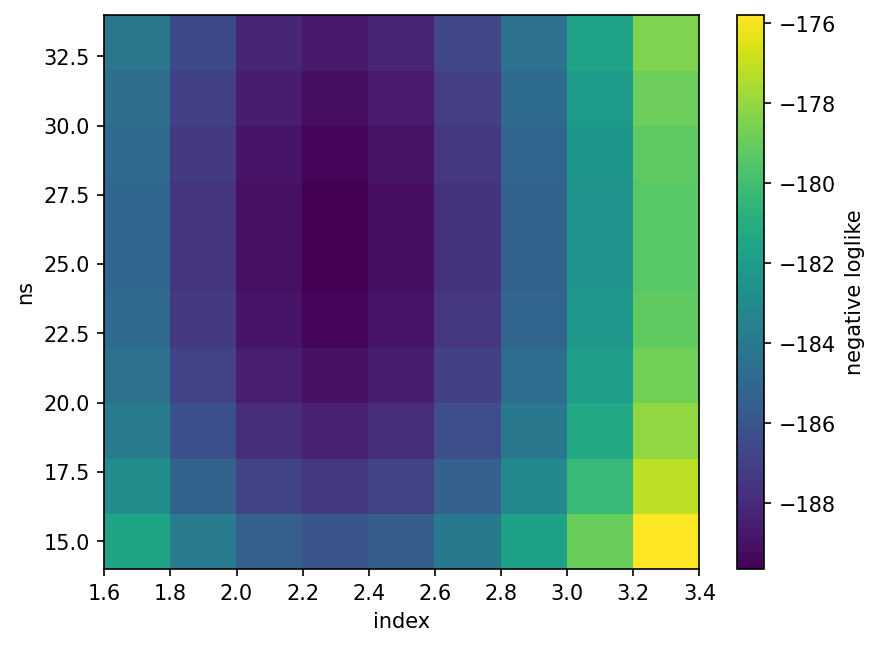

In [22]:
index = np.arange(1.7, 3.4, step=0.2)
index_pl = np.arange(1.6, 3.5, step=0.2)
ns_pl = np.arange(14.0, 36, step=2.0)
ns = np.arange(15, 35, step=2.0)
ii, nn = np.meshgrid(index, ns, indexing="ij")
ll = np.zeros(ii.flatten().shape)

for c, (i, n) in enumerate(zip(ii.flatten(), nn.flatten())):
    ll[c] = likelihood._func_to_minimize(n, i)

fig, ax = plt.subplots(dpi=150)

pcol = ax.pcolor(index_pl, ns_pl, ll.reshape(ii.shape).T)
pcol_ax = fig.colorbar(pcol)
pcol_ax.set_label("negative loglike")
ax.set_xlabel("index")
ax.set_ylabel("ns")

For the simulation-based energy likelihood used in the following, the profile o `index` has some edges. This is due to the interpolation done by the energy likelihood. We fed it simulation for discreet values of `index`. We cannot sensibly interpolate the likelihood of a given energy to any index, this leads to Heaviside-like discontinuities in the global (spatial + energy) likelihood. Instead, `PointSourceLikelihood` calculates the likelihood for the next simulated values of `index`, e.g. asking for an index 2.3 would lead to 2.0 and 2.5, and interpolate linearly between the resulting likelihoods. The precision of this method can be improved by providing simulations on a denser grid of spectral indices.

The error provided by `migrad()` is unreasonably small.

In [23]:
energy_likelihood = MarginalisedEnergyLikelihood2021(
    np.round(np.arange(1.5, 4.1, 0.2), decimals=1), "data", "p_IC86_II", np.deg2rad(30)
)
energy_likelihood._min_index = 1.55
energy_likelihood._max_index = 3.85
likelihood = PointSourceLikelihood(
    spatial_likelihood,
    energy_likelihood,
    events.ra[events.periods[0]],
    events.dec[events.periods[0]],
    events.reco_energy[events.periods[0]],
    events.ang_err[events.periods[0]],
    source_coord,
    cosz_bins=np.linspace(-1, 1, num=51),
)
likelihood._bg_index = 3.7
likelihood._bg_energy_likelihood = None

data/p_IC86_II_index_1.5.h5
data/p_IC86_II_index_1.7.h5
data/p_IC86_II_index_1.9.h5
data/p_IC86_II_index_2.1.h5
data/p_IC86_II_index_2.3.h5
data/p_IC86_II_index_2.5.h5
data/p_IC86_II_index_2.7.h5
data/p_IC86_II_index_2.9.h5
data/p_IC86_II_index_3.1.h5
data/p_IC86_II_index_3.3.h5
data/p_IC86_II_index_3.5.h5
data/p_IC86_II_index_3.7.h5
data/p_IC86_II_index_3.9.h5


In [24]:
likelihood.get_test_statistic()

429.37018357983

In [25]:
m = likelihood._minimize()

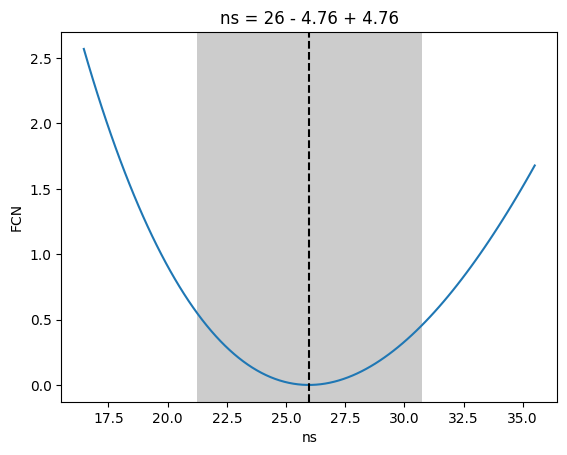

In [26]:
_ = m.draw_profile("ns")

Text(0.5, 1.0, 'index = 2.3 - 0.2 + 0.2')

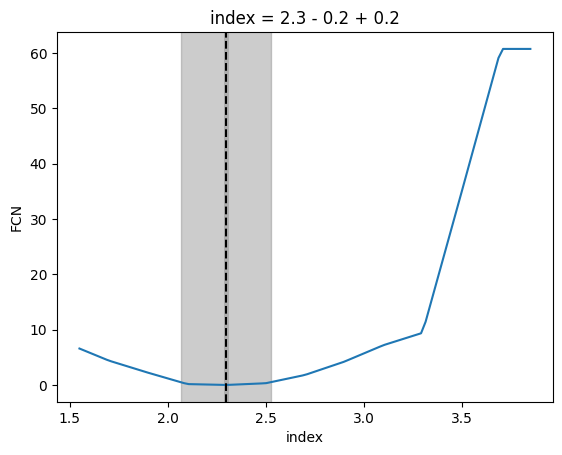

In [27]:
# Do this because for this interpolated function minuit can't compute reliable errors
index, llh = m.draw_profile(
    "index",
    bound=(
        likelihood._energy_likelihood._min_index,
        likelihood._energy_likelihood._max_index,
    ),
)

lower_lim = np.interp(
    llh.min() + 0.5,
    np.flip(llh[: np.nonzero(llh == llh.min())[0][0]]),
    np.flip(index[: np.nonzero(llh == llh.min())[0][0]]),
)
upper_lim = np.interp(
    llh.min() + 0.5,
    llh[np.nonzero(llh == llh.min())[0][0] :],
    index[np.nonzero(llh == llh.min())[0][0] :],
)
lims = plt.ylim()
plt.fill_betweenx(
    [lims[0] - 1, lims[1] + 1], lower_lim, upper_lim, alpha=0.4, color="grey"
)
plt.ylim(lims)
plt.title(
    f"index = {m.values['index']:.1f} - {m.values['index']-lower_lim:.1f} + {abs(m.values['index']-upper_lim):.1f}"
)

# Time dependent point source analysis

Encompassing multiple data seasons, although shown only for one (the same as above), uses a single `ns`, which is distributed among the seasons with the number of expected events for `gamma` and the provided observational times (`times`) as relative weight.

In [28]:
events = SimEvents.load_from_h5("h5_test.hdf5")
source_coords = (np.pi, np.deg2rad(30))
# energy_likelihood = MarginalisedIntegratedEnergyLikelihood(irf, aeff, new_reco_bins)
# index_list = list(np.arange(1.5, 4.25, 0.25))
tllh = TimeDependentPointSourceLikelihood(
    source_coords,
    ["IC86_II"],
    events.ra,
    events.dec,
    events.reco_energy,
    events.ang_err,
    which="both",
    times={"IC86_II": 1},
    sigma=2,
    band_width_factor=5,
)

m = tllh._minimize()

m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -178.1                     │              Nfcn = 61               │
│ EDM = 1.47e-07 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns          │    26     │     5     │            │            │    0    │   204   │       │
│ 1 │ index       │   2.30    │   0.19    │            │            │   1.5   │    5    │       │
│ 2 │ weight      │    0.0    │    0.1    │            │            │    0    │    1    │  yes  │
│ 3 │ index_astro │    2.5    │    0.1    │            │            │   1.5   │    5    │  yes  │
│ 4 │ index_atmo  │    3.7    │    0.1    │            │            │   1.5   │    5    │  yes  │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────┬─────────────────────────────────────────────────────────────┐
│             │          ns       index      weight index_astro  index_atmo │
├─────────────┼─────────────────────────────────────────────────────────────┤
│          ns │        22.7        0.00           0           0           0 │
│       index │        0.00      0.0367        0.00        0.00        0.00 │
│      weight │           0        0.00           0           0           0 │
│ index_astro │           0        0.00           0           0           0 │
│  index_atmo │           0        0.00           0           0           0 │
└─────────────┴─────────────────────────────────────────────────────────────┘

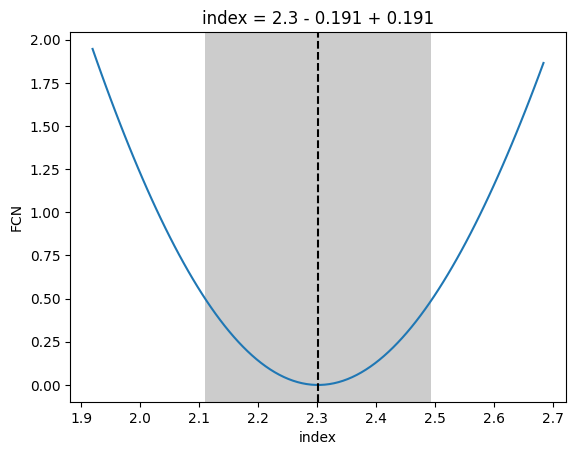

In [29]:
_ = m.draw_profile("index")

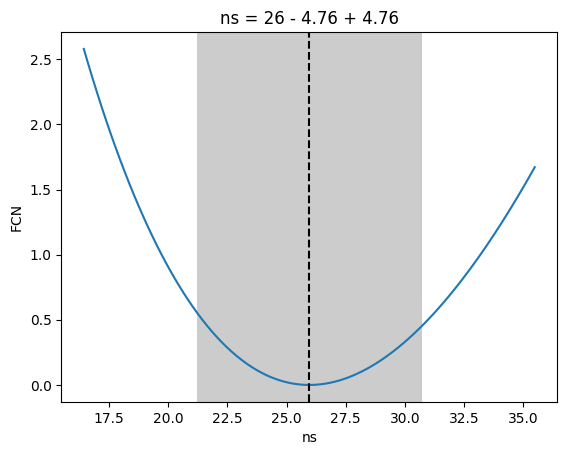

In [30]:
_ = m.draw_profile("ns")

There is also a method to use only the events within the selected declination band and their energy to fit the background index. Default setting is one background index (`index_atmo`), using two at once does not lead to a converging fit right now.

In [31]:
tllh._minimize_bg()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 470.2                      │              Nfcn = 212              │
│ EDM = nan (Goal: 0.0001)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ weight      │    0.0    │    0.1    │            │            │    0    │    1    │  yes  │
│ 1 │ index_astro │    2.5    │    0.1    │            │            │   1.5   │    5    │  yes  │
│ 2 │ index_atmo  │    3.3    │    0.0    │            │            │   1.5   │    5    │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

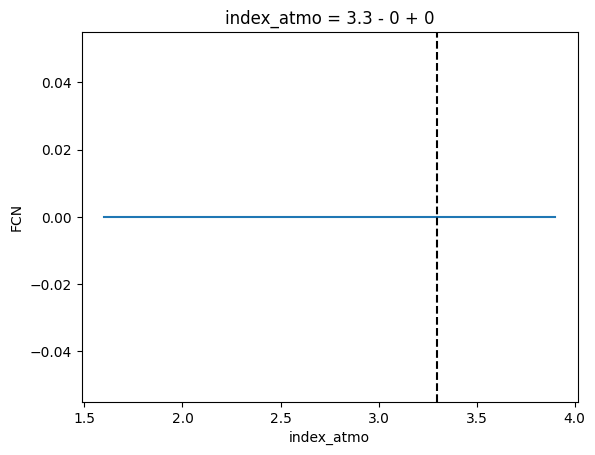

In [32]:
_ = tllh.m.draw_profile("index_atmo", bound=(1.6, 3.9))